# Cabecera

**Nombre completo del estudiante**: [TU NOMBRE AQUI]

**Grupo**: [TU GRUPO]

**Carrera**: Ingeniería en Inteligencia Artificial

**Fecha de última modificación**: 04/05/2025

---

## Descripción detallada del programa

Este programa implementa diferentes algoritmos de extracción de frases clave y resumen automático de textos aplicados a las tres primeras cartas del libro "Frankenstein" de Mary Shelley. Los algoritmos utilizados son:

1. TF-IDF (Term Frequency-Inverse Document Frequency)
2. Frecuencia de palabras normalizada
3. RAKE (Rapid Automatic Keyword Extraction)
4. TextRank
5. BERT (Bidirectional Encoder Representations from Transformers)
6. LSA (Latent Semantic Analysis)

### Datos de entrada:
- **Texto de entrada**: Las tres primeras cartas del libro "Frankenstein" descargado de Project Gutenberg.
- **Algoritmos de procesamiento**: Módulos de NLTK, SpaCy, Transformers y otras bibliotecas especializadas.

### Salidas esperadas:
- Resúmenes extractivos de cada carta usando cada algoritmo
- Métricas de tiempo de ejecución
- Análisis comparativo de resultados

---

## PRÁCTICA 3: IDENTIFICACIÓN DE FRASES CLAVE Y RESUMEN AUTOMÁTICO DE TEXTO

### 1. Importación de bibliotecas

In [140]:
# Bibliotecas principales
import requests
import re
import time
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas as pd

# Algoritmos específicos
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from rake_nltk import Rake
import networkx as nx
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer  # Para BERT real

# Descarga de recursos NLTK necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Cargar SpaCy
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\keval\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\keval\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\keval\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\keval\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 2. Generación del corpus: Descarga y extracción de las tres primeras cartas de Frankenstein

In [15]:
def obtener_cartas_frankenstein():

    url = "https://www.gutenberg.org/cache/epub/84/pg84.txt"
    response = requests.get(url)
    texto = response.text
    # Esta expresión regular coincide con el patrón de las cartas en el texto
    patron = r'Letter ([123][\s\S]+?)(?=Letter [234]|Chapter 1)'

    # Buscar todas las coincidencias
    cartas_raw = re.findall(patron, texto, re.DOTALL)

    # Tomar solo las tres primeras cartas
    cartas_completas = cartas_raw[:3]

    # Eliminar las primeras tres coincidencias que son solo los títulos
    cartas = []
    for i, carta in enumerate(cartas_completas):
        if i >= 3:  # Solo procesamos las cartas completas
            cartas.append(carta.strip())

    # Si tenemos resultados duplicados o necesitamos filtrar más
    # Podemos obtener las cartas por su contenido específico
    if not cartas or len(cartas) < 3:
        # Buscamos patrones específicos dentro de cada carta
        carta1 = re.search(r'Letter 1\r\n\r\n_To Mrs\. Saville, England\._[\s\S]+?(?=Letter 2)', texto)
        carta2 = re.search(r'Letter 2\r\n\r\n_To Mrs\. Saville, England\._[\s\S]+?(?=Letter 3)', texto)
        carta3 = re.search(r'Letter 3\r\n\r\n_To Mrs\. Saville, England\._[\s\S]+?(?=Letter 4|Chapter 1)', texto)

        cartas = []
        if carta1:
            cartas.append(carta1.group(0).strip())
        if carta2:
            cartas.append(carta2.group(0).strip())
        if carta3:
            cartas.append(carta3.group(0).strip())

    return cartas

# Obtener las cartas
cartas = obtener_cartas_frankenstein()

# Verificar que tenemos las tres cartas
print(f"Cartas extraídas: {len(cartas)}")
for i, carta in enumerate(cartas):
    print(f"Longitud carta {i+1}: {len(carta)} caracteres")
    print(f"Primeras 200 caracteres:")
    print(carta[:200])
    print("-" * 50)

Cartas extraídas: 3
Longitud carta 1: 6967 caracteres
Primeras 200 caracteres:
Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17—.


You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded 
--------------------------------------------------
Longitud carta 2: 7478 caracteres
Primeras 200 caracteres:
Letter 2

_To Mrs. Saville, England._

Archangel, 28th March, 17—.


How slowly the time passes here, encompassed as I am by frost and snow!
Yet a second step is taken towards my enterprise. I
--------------------------------------------------
Longitud carta 3: 1747 caracteres
Primeras 200 caracteres:
Letter 3

_To Mrs. Saville, England._

July 7th, 17—.


My dear Sister,

I write a few lines in haste to say that I am safe—and well advanced
on my voyage. This letter will reach England by 
--------------------------------------------------


In [16]:
cartas = obtener_cartas_frankenstein()

In [17]:
print(cartas[0])

Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17—.


You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such evil
forebodings. I arrived here yesterday, and my first task is to assure
my dear sister of my welfare and increasing confidence in the success
of my undertaking.

I am already far north of London, and as I walk in the streets of
Petersburgh, I feel a cold northern breeze play upon my cheeks, which
braces my nerves and fills me with delight. Do you understand this
feeling? This breeze, which has travelled from the regions towards
which I am advancing, gives me a foretaste of those icy climes.
Inspirited by this wind of promise, my daydreams become more fervent
and vivid. I try in vain to be persuaded that the pole is the seat of
frost and desolation; it ever presents itself to my imagination as the
region of beauty and delight. There, Margaret, the sun is for ever
visible, its broad disk

In [18]:
print(cartas[1])

Letter 2

_To Mrs. Saville, England._

Archangel, 28th March, 17—.


How slowly the time passes here, encompassed as I am by frost and snow!
Yet a second step is taken towards my enterprise. I have hired a
vessel and am occupied in collecting my sailors; those whom I have
already engaged appear to be men on whom I can depend and are certainly
possessed of dauntless courage.

But I have one want which I have never yet been able to satisfy, and the
absence of the object of which I now feel as a most severe evil, I have no
friend, Margaret: when I am glowing with the enthusiasm of success, there
will be none to participate my joy; if I am assailed by disappointment, no
one will endeavour to sustain me in dejection. I shall commit my thoughts
to paper, it is true; but that is a poor medium for the communication of
feeling. I desire the company of a man who could sympathise with me, whose
eyes would reply to mine. You may deem me romantic, my dear sister, but I
bitterly feel the want of a f

In [19]:
print(cartas[2])

Letter 3

_To Mrs. Saville, England._

July 7th, 17—.


My dear Sister,

I write a few lines in haste to say that I am safe—and well advanced
on my voyage. This letter will reach England by a merchantman now on
its homeward voyage from Archangel; more fortunate than I, who may not
see my native land, perhaps, for many years. I am, however, in good
spirits: my men are bold and apparently firm of purpose, nor do the
floating sheets of ice that continually pass us, indicating the dangers
of the region towards which we are advancing, appear to dismay them. We
have already reached a very high latitude; but it is the height of
summer, and although not so warm as in England, the southern gales,
which blow us speedily towards those shores which I so ardently desire
to attain, breathe a degree of renovating warmth which I had not
expected.

No incidents have hitherto befallen us that would make a figure in a
letter. One or two stiff gales and the springing of a leak are
accidents which experien

### 3. Normalización de textos

Para cada documento, aplicaremos las siguientes técnicas de normalización:
1. Eliminación de encabezados y formato de Project Gutenberg
2. Limpieza de caracteres especiales
3. Tokenización
4. Eliminación de palabras vacías
5. Lematización

In [91]:
def normalizar_para_tfidf(texto):
    """Normaliza texto para TF-IDF conservando estructura"""
    texto = texto.replace('\r\n', ' ')
    texto = texto.replace('Letter 1', '').replace('Letter 2', '').replace('Letter 3', '')
    texto = re.sub(r'_.*?_', ' ', texto)
    texto = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [92]:
def normalizar_para_frecuencia(texto):
    """Normaliza texto para frecuencia de palabras"""
    texto = texto.replace('\r\n', ' ')
    texto = texto.replace('Letter 1', '').replace('Letter 2', '').replace('Letter 3', '')
    texto = re.sub(r'_.*?_', ' ', texto)
    texto = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [95]:
def normalizar_para_rake(texto):
    """Normaliza texto para RAKE - más conservador"""
    texto = texto.replace('\r\n', ' ')
    texto = texto.replace('Letter 1', '').replace('Letter 2', '').replace('Letter 3', '')
    texto = re.sub(r'_.*?_', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [94]:
def normalizar_para_textrank(texto):
    """Normaliza texto para TextRank"""
    texto = texto.replace('\r\n', ' ')
    texto = texto.replace('Letter 1', '').replace('Letter 2', '').replace('Letter 3', '')
    texto = re.sub(r'_.*?_', ' ', texto)
    texto = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [96]:
def normalizar_para_bert(texto):
    """Normaliza texto para BERT - mínima normalización"""
    texto = texto.replace('\r\n', ' ')
    texto = texto.replace('Letter 1', '').replace('Letter 2', '').replace('Letter 3', '')
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [97]:
def normalizar_para_lsa(texto):
    """Normaliza texto para LSA"""
    texto = texto.replace('\r\n', ' ')
    texto = texto.replace('Letter 1', '').replace('Letter 2', '').replace('Letter 3', '')
    texto = re.sub(r'_.*?_', ' ', texto)
    texto = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    texto = texto.lower()  # LSA suele funcionar mejor con minúsculas
    return texto

In [99]:
cartas_tfidf = [normalizar_para_tfidf(carta) for carta in cartas]
cartas_frecuencia = [normalizar_para_frecuencia(carta) for carta in cartas]
cartas_rake = [normalizar_para_rake(carta) for carta in cartas]
cartas_textrank = [normalizar_para_textrank(carta) for carta in cartas]
cartas_bert = [normalizar_para_bert(carta) for carta in cartas]
cartas_lsa = [normalizar_para_lsa(carta) for carta in cartas]

In [100]:
# TF-IDF para carta 1
start_time = time.time()
resumen_carta1_tfidf = resumen_tfidf(cartas_tfidf[0])
tiempo_carta1_tfidf = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta1_tfidf:.3f} segundos")
print("Resumen:", resumen_carta1_tfidf)

Tiempo de ejecución: 0.025 segundos
Resumen: ['These are my enticements, and they are sufficient to conquer all fear of danger or death and to induce me to commence this laborious voyage with the joy a child feels when he embarks in a little boat, with his holiday mates, on an expedition of discovery up his native river.', 'But supposing all these conjectures to be false, you cannot contest the inestimable benefit which I shall confer on all mankind, to the last generation, by discovering a passage near the pole to those countries, to reach which at present so many months are requisite or by ascertaining the secret of the magnet, which, if at all possible, can only be effected by an undertaking such as mine.', 'I accompanied the whale fishers on several expeditions to the North Sea I voluntarily endured cold, famine, thirst, and want of sleep I often worked harder than the common sailors during the day and devoted my nights to the study of mathematics, the theory of medicine, and those

In [101]:
# TF-IDF para carta 2
start_time = time.time()
resumen_carta2_tfidf = resumen_tfidf(cartas_tfidf[1])
tiempo_carta2_tfidf = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta2_tfidf:.3f} segundos")
print("Resumen:", resumen_carta2_tfidf)

Tiempo de ejecución: 0.012 segundos
Resumen: ['But I have one want which I have never yet been able to satisfy, and the absence of the object of which I now feel as a most severe evil, I have no friend, Margaret when I am glowing with the enthusiasm of success, there will be none to participate my joy if I am assailed by disappointment, no one will endeavour to sustain me in dejection.', 'At that age I became acquainted with the celebrated poets of our own country but it was only when it had ceased to be in my power to derive its most important benefits from such a conviction that I perceived the necessity of becoming acquainted with more languages than that of my native country.', 'A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary, and when I heard of a mariner equally no

In [102]:
# TF-IDF para carta 3
start_time = time.time()
resumen_carta3_tfidf = resumen_tfidf(cartas_tfidf[2])
tiempo_carta3_tfidf = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta3_tfidf:.3f} segundos")
print("Resumen:", resumen_carta3_tfidf)

Tiempo de ejecución: 0.003 segundos
Resumen: ['This letter will reach England by a merchantman now on its homeward voyage from Archangel more fortunate than I, who may not see my native land, perhaps, for many years.', 'I am, however, in good spirits my men are bold and apparently firm of purpose, nor do the floating sheets of ice that continually pass us, indicating the dangers of the region towards which we are advancing, appear to dismay them.', 'We have already reached a very high latitude but it is the height of summer, and although not so warm as in England, the southern gales, which blow us speedily towards those shores which I so ardently desire to attain, breathe a degree of renovating warmth which I had not expected.', 'One or two stiff gales and the springing of a leak are accidents which experienced navigators scarcely remember to record, and I shall be well content if nothing worse happen to us during our voyage.']


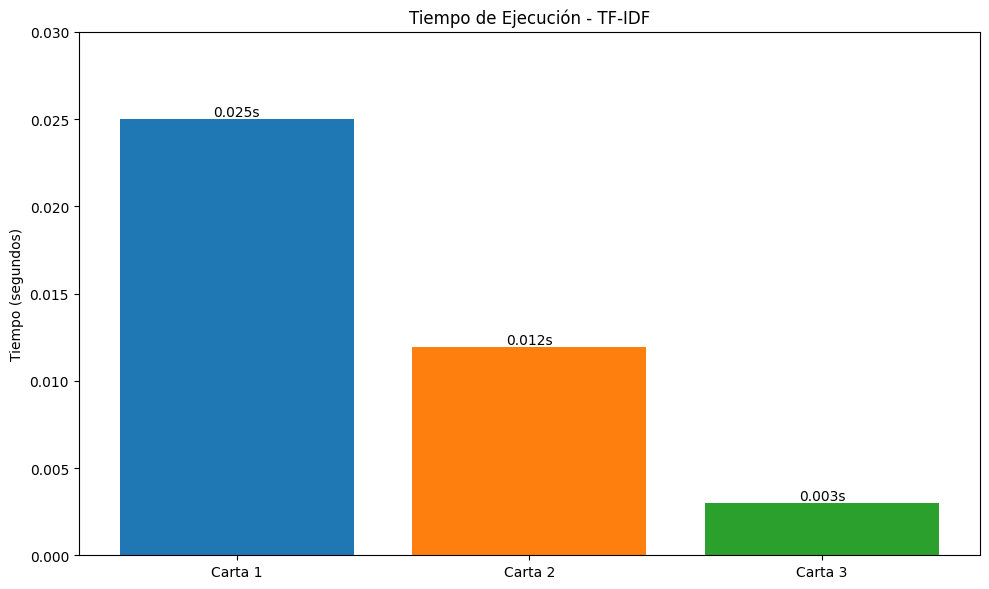

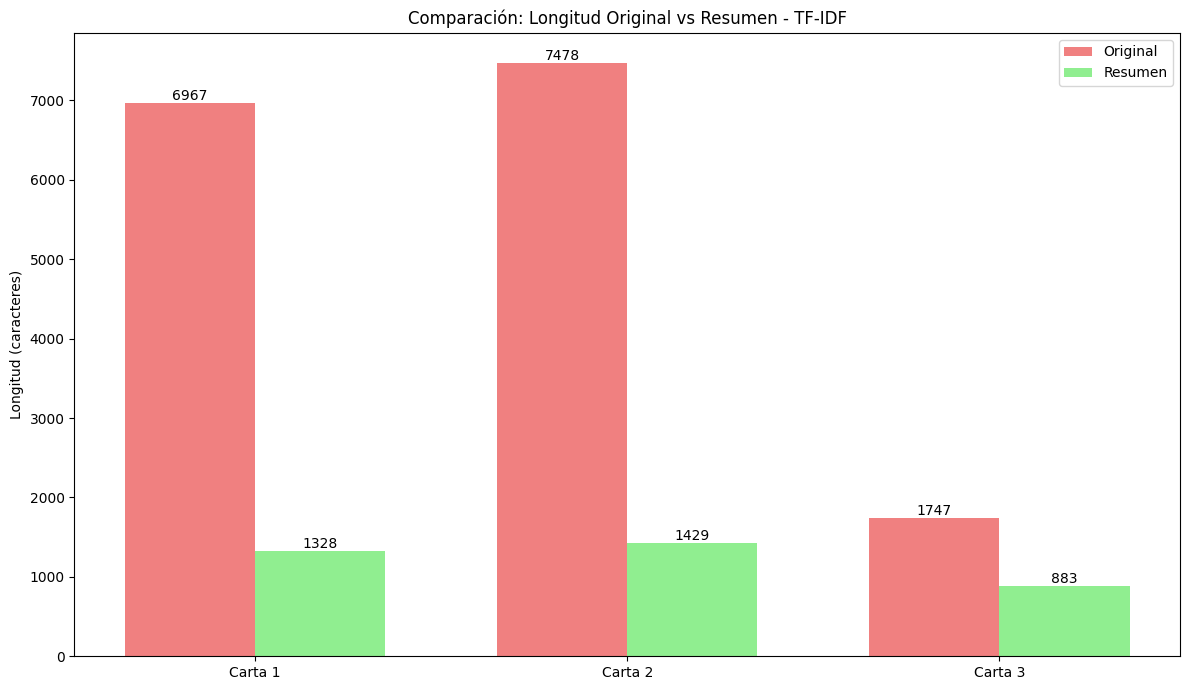

In [109]:
# Gráfica comparativa TF-IDF
import matplotlib.pyplot as plt
import numpy as np

tiempos_tfidf = [tiempo_carta1_tfidf, tiempo_carta2_tfidf, tiempo_carta3_tfidf]
cartas_labels = ['Carta 1', 'Carta 2', 'Carta 3']

# Gráfica de tiempos
plt.figure(figsize=(10, 6))
bars = plt.bar(cartas_labels, tiempos_tfidf, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Ejecución - TF-IDF')
plt.ylim(0, max(tiempos_tfidf) * 1.2)

# Agregar valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Gráfica de reducción de longitud (original vs resumen)
longitudes_originales = [len(cartas[0]), len(cartas[1]), len(cartas[2])]
longitudes_resumenes = [len(' '.join(resumen_carta1_tfidf)), 
                        len(' '.join(resumen_carta2_tfidf)), 
                        len(' '.join(resumen_carta3_tfidf))]

x = np.arange(len(cartas_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, longitudes_originales, width, label='Original', color='lightcoral')
bars2 = ax.bar(x + width/2, longitudes_resumenes, width, label='Resumen', color='lightgreen')

ax.set_ylabel('Longitud (caracteres)')
ax.set_title('Comparación: Longitud Original vs Resumen - TF-IDF')
ax.set_xticks(x)
ax.set_xticklabels(cartas_labels)
ax.legend()

# Agregar valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 4.2 Frecuencia de palabras normalizada

In [104]:
def resumen_frecuencia(texto, num_oraciones=4):
    """Genera resumen usando frecuencia de palabras normalizada"""
    # Tokenizar oraciones
    oraciones = sent_tokenize(texto)
    
    # Obtener palabras y eliminar stopwords
    palabras = word_tokenize(texto.lower())
    stop_words = set(stopwords.words('english'))
    palabras_filtradas = [palabra for palabra in palabras if palabra.isalpha() and palabra not in stop_words]
    
    # Calcular frecuencia de palabras
    frecuencia = {}
    for palabra in palabras_filtradas:
        if palabra in frecuencia:
            frecuencia[palabra] += 1
        else:
            frecuencia[palabra] = 1
    
    # Normalizar frecuencias
    max_freq = max(frecuencia.values())
    for palabra in frecuencia:
        frecuencia[palabra] = frecuencia[palabra] / max_freq
    
    # Puntuar oraciones
    puntajes = []
    for oracion in oraciones:
        palabras_oracion = word_tokenize(oracion.lower())
        puntaje = 0
        contador = 0
        
        for palabra in palabras_oracion:
            if palabra in frecuencia:
                puntaje += frecuencia[palabra]
                contador += 1
        
        if contador > 0:
            puntajes.append(puntaje / contador)
        else:
            puntajes.append(0)
    
    # Obtener índices de mejor puntuación
    indices_top = sorted(range(len(puntajes)), key=lambda i: puntajes[i], reverse=True)[:num_oraciones]
    indices_top = sorted(indices_top)
    
    resumen = [oraciones[i] for i in indices_top]
    return resumen

In [105]:
# Frecuencia para carta 1
start_time = time.time()
resumen_carta1_frecuencia = resumen_frecuencia(cartas_frecuencia[0])
tiempo_carta1_frecuencia = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta1_frecuencia:.3f} segundos")
print("Resumen:", resumen_carta1_frecuencia)

Tiempo de ejecución: 0.021 segundos
Resumen: ['St. Petersburgh, Dec. 11th, 17 .', 'What may not be expected in a country of eternal light?', 'And now, dear Margaret, do I not deserve to accomplish some great purpose?', 'If I succeed, many, many months, perhaps years, will pass before you and I may meet.']


In [106]:
# Frecuencia para carta 2
start_time = time.time()
resumen_carta2_frecuencia = resumen_frecuencia(cartas_frecuencia[1])
tiempo_carta2_frecuencia = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta2_frecuencia:.3f} segundos")
print("Resumen:", resumen_carta2_frecuencia)

Tiempo de ejecución: 0.012 segundos
Resumen: ['You may deem me romantic, my dear sister, but I bitterly feel the want of a friend.', 'How would such a friend repair the faults of your poor brother!', 'Well, these are useless complaints I shall certainly find no friend on the wide ocean, nor even here in Archangel, among merchants and seamen.', 'Remember me with affection, should you never hear from me again.']


In [107]:
# Frecuencia para carta 3
start_time = time.time()
resumen_carta3_frecuencia = resumen_frecuencia(cartas_frecuencia[2])
tiempo_carta3_frecuencia = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta3_frecuencia:.3f} segundos")
print("Resumen:", resumen_carta3_frecuencia)

Tiempo de ejecución: 0.005 segundos
Resumen: ['My dear Sister, I write a few lines in haste to say that I am safe and well advanced on my voyage.', 'No incidents have hitherto befallen us that would make a figure in a letter.', 'One or two stiff gales and the springing of a leak are accidents which experienced navigators scarcely remember to record, and I shall be well content if nothing worse happen to us during our voyage.', 'My swelling heart involuntarily pours itself out thus.']


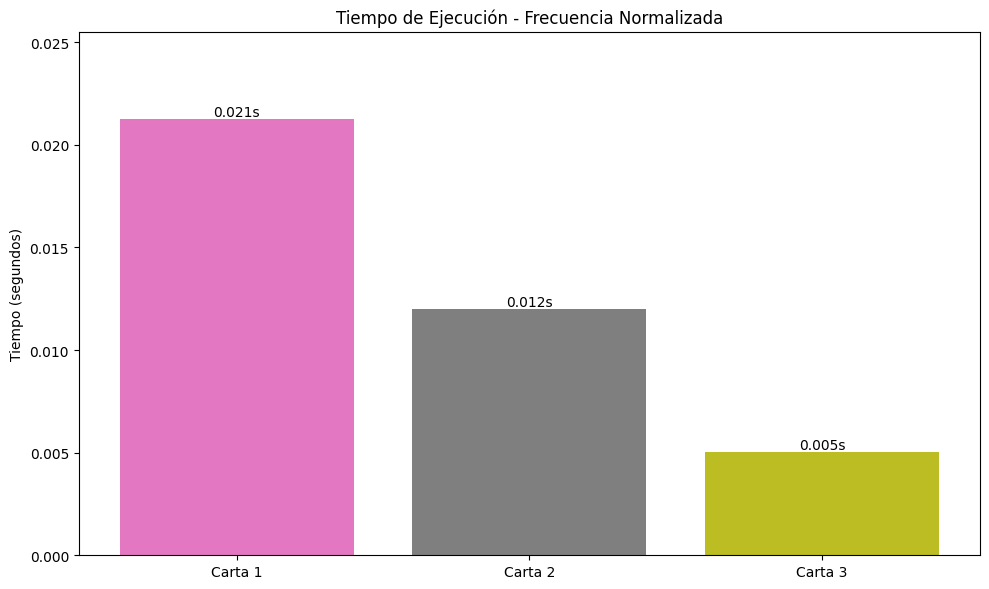

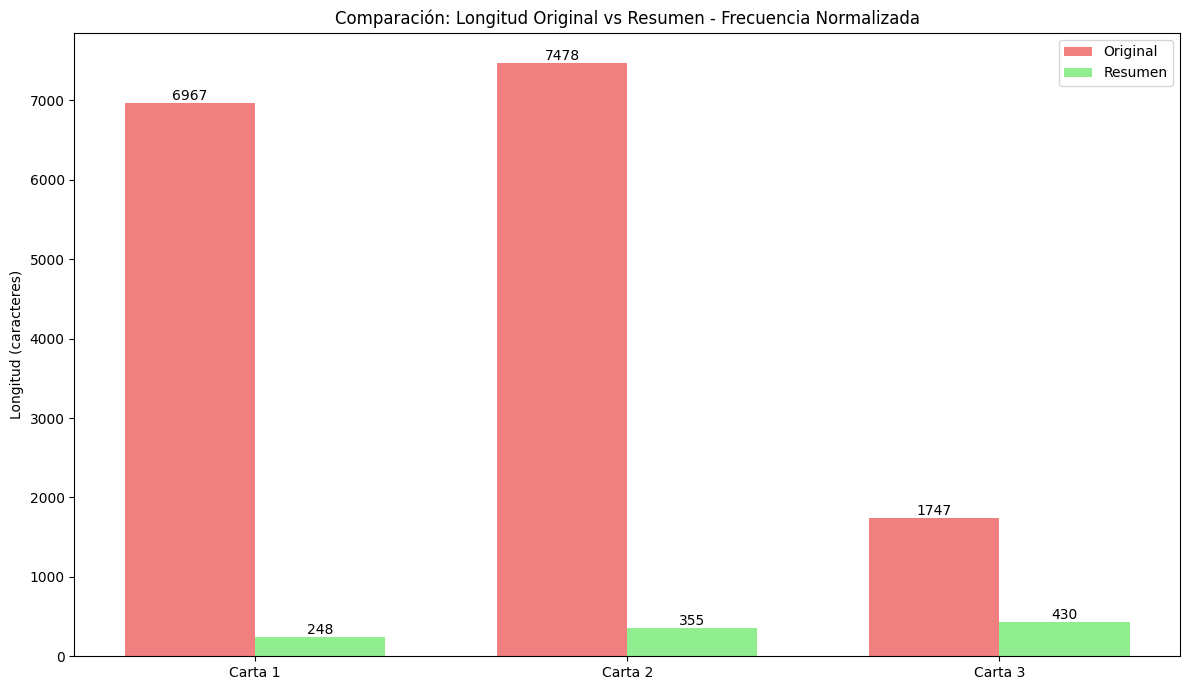

In [111]:
# Gráfica comparativa Frecuencia
tiempos_frecuencia = [tiempo_carta1_frecuencia, tiempo_carta2_frecuencia, tiempo_carta3_frecuencia]

# Gráfica de tiempos
plt.figure(figsize=(10, 6))
bars = plt.bar(cartas_labels, tiempos_frecuencia, color=['#e377c2', '#7f7f7f', '#bcbd22'])
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Ejecución - Frecuencia Normalizada')
plt.ylim(0, max(tiempos_frecuencia) * 1.2)

# Agregar valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Gráfica de reducción de longitud (original vs resumen)
longitudes_originales = [len(cartas[0]), len(cartas[1]), len(cartas[2])]
longitudes_resumenes = [len(' '.join(resumen_carta1_frecuencia)), 
                        len(' '.join(resumen_carta2_frecuencia)), 
                        len(' '.join(resumen_carta3_frecuencia))]

x = np.arange(len(cartas_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, longitudes_originales, width, label='Original', color='lightcoral')
bars2 = ax.bar(x + width/2, longitudes_resumenes, width, label='Resumen', color='lightgreen')

ax.set_ylabel('Longitud (caracteres)')
ax.set_title('Comparación: Longitud Original vs Resumen - Frecuencia Normalizada')
ax.set_xticks(x)
ax.set_xticklabels(cartas_labels)
ax.legend()

# Agregar valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 4.3 RAKE (Rapid Automatic Keyword Extraction)

In [112]:
def resumen_rake(texto, num_oraciones=4):
    """Genera resumen usando RAKE para extraer frases clave"""
    # Inicializar RAKE
    r = Rake()
    r.extract_keywords_from_text(texto)
    
    # Obtener frases clave con puntuación
    frases = r.get_ranked_phrases_with_scores()
    
    # Obtener oraciones del texto
    oraciones = sent_tokenize(texto)
    
    # Puntuar oraciones basándose en la presencia de frases clave
    puntajes = []
    for oracion in oraciones:
        puntaje = 0
        for puntuacion, frase in frases:
            if frase.lower() in oracion.lower():
                puntaje += puntuacion
        puntajes.append(puntaje)
    
    # Obtener índices de las oraciones mejor puntuadas
    indices_top = sorted(range(len(puntajes)), 
                        key=lambda i: puntajes[i], 
                        reverse=True)[:num_oraciones]
    
    # Ordenar por posición original
    indices_top = sorted(indices_top)
    
    resumen = [oraciones[i] for i in indices_top]
    return resumen

In [113]:
# RAKE para carta 1
start_time = time.time()
resumen_carta1_rake = resumen_rake(cartas_rake[0])
tiempo_carta1_rake = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta1_rake:.3f} segundos")
print("Resumen:", resumen_carta1_rake)

Tiempo de ejecución: 0.028 segundos
Resumen: ['I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight.', 'There—for with your leave, my sister, I will put some trust in preceding navigators—there snow and frost are banished; and, sailing over a calm sea, we may be wafted to a land surpassing in wonders and in beauty every region hitherto discovered on the habitable globe.', 'But supposing all these conjectures to be false, you cannot contest the inestimable benefit which I shall confer on all mankind, to the last generation, by discovering a passage near the pole to those countries, to reach which at present so many months are requisite; or by ascertaining the secret of the magnet, which, if at all possible, can only be effected by an undertaking such as mine.', 'I accompanied the whale-fishers on several expeditions to the North Sea; I voluntarily endured cold, f

In [114]:
# RAKE para carta 2
start_time = time.time()
resumen_carta2_rake = resumen_rake(cartas_rake[1])
tiempo_carta2_rake = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta2_rake:.3f} segundos")
print("Resumen:", resumen_carta2_rake)

Tiempo de ejecución: 0.023 segundos
Resumen: ['But I have one want which I have never yet been able to satisfy, and the absence of the object of which I now feel as a most severe evil, I have no friend, Margaret: when I am glowing with the enthusiasm of success, there will be none to participate my joy; if I am assailed by disappointment, no one will endeavour to sustain me in dejection.', 'It is true that I have thought more and that my daydreams are more extended and magnificent, but they want (as the painters call it) and I greatly need a friend who would have sense enough not to despise me as romantic, and affection enough for me to endeavour to regulate my mind.', 'A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his 

In [115]:
# RAKE para carta 3
start_time = time.time()
resumen_carta3_rake = resumen_rake(cartas_rake[2])
tiempo_carta3_rake = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta3_rake:.3f} segundos")
print("Resumen:", resumen_carta3_rake)

Tiempo de ejecución: 0.004 segundos
Resumen: ['This letter will reach England by a merchantman now on its homeward voyage from Archangel; more fortunate than I, who may not see my native land, perhaps, for many years.', 'I am, however, in good spirits: my men are bold and apparently firm of purpose, nor do the floating sheets of ice that continually pass us, indicating the dangers of the region towards which we are advancing, appear to dismay them.', 'We have already reached a very high latitude; but it is the height of summer, and although not so warm as in England, the southern gales, which blow us speedily towards those shores which I so ardently desire to attain, breathe a degree of renovating warmth which I had not expected.', 'One or two stiff gales and the springing of a leak are accidents which experienced navigators scarcely remember to record, and I shall be well content if nothing worse happen to us during our voyage.']


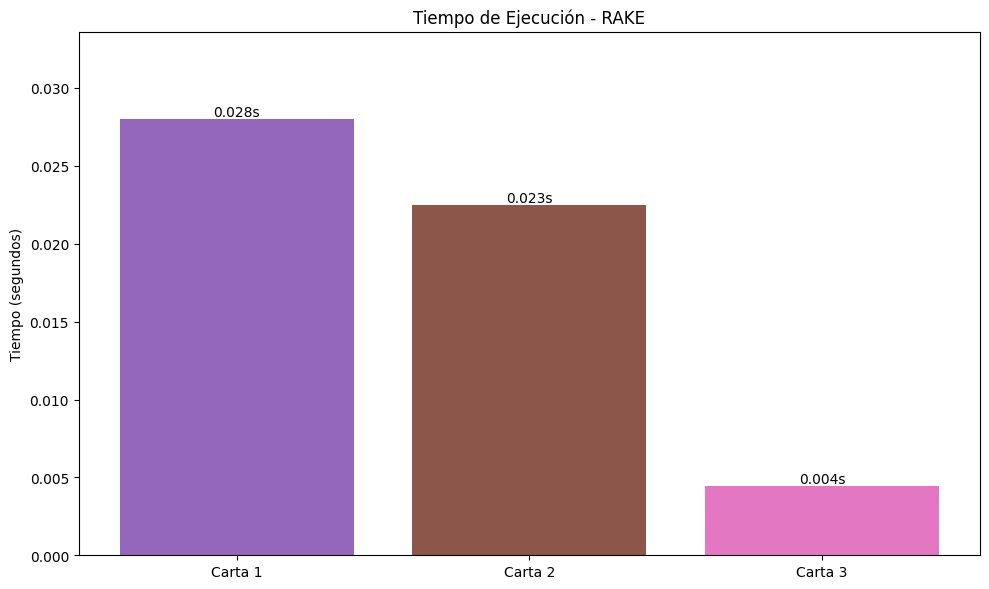

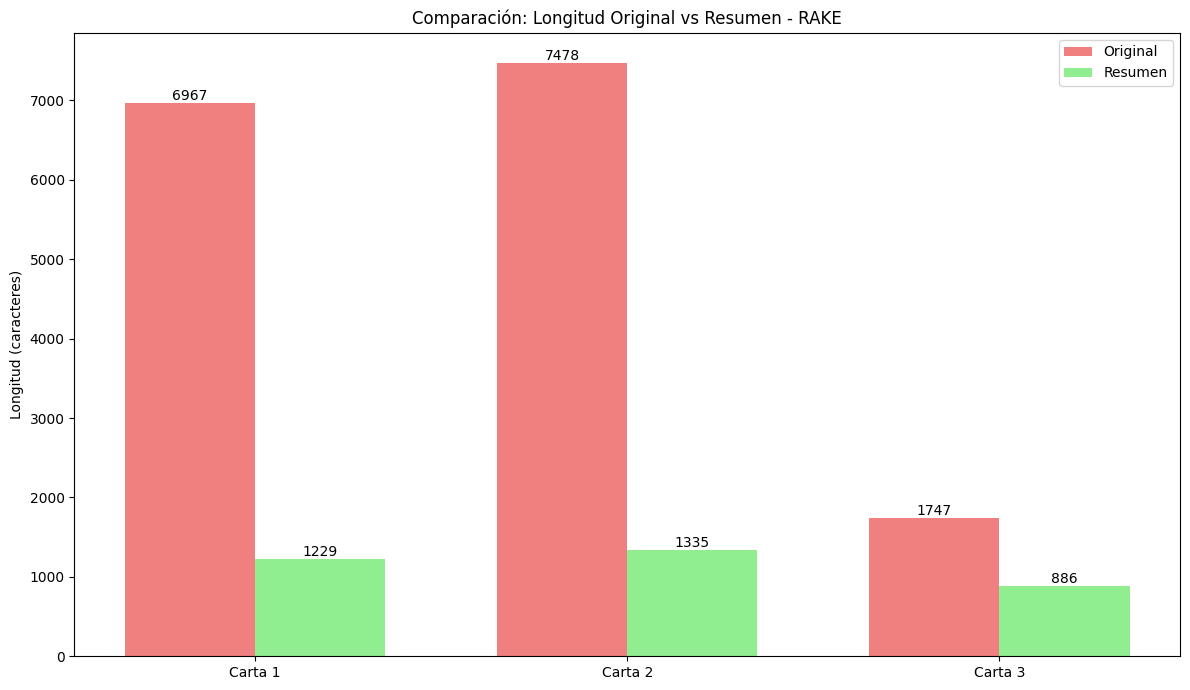

In [116]:
# Gráfica comparativa RAKE
tiempos_rake = [tiempo_carta1_rake, tiempo_carta2_rake, tiempo_carta3_rake]

# Gráfica de tiempos
plt.figure(figsize=(10, 6))
bars = plt.bar(cartas_labels, tiempos_rake, color=['#9467bd', '#8c564b', '#e377c2'])
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Ejecución - RAKE')
plt.ylim(0, max(tiempos_rake) * 1.2)

# Agregar valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Gráfica de reducción de longitud (original vs resumen)
longitudes_originales = [len(cartas[0]), len(cartas[1]), len(cartas[2])]
longitudes_resumenes = [len(' '.join(resumen_carta1_rake)), 
                        len(' '.join(resumen_carta2_rake)), 
                        len(' '.join(resumen_carta3_rake))]

x = np.arange(len(cartas_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, longitudes_originales, width, label='Original', color='lightcoral')
bars2 = ax.bar(x + width/2, longitudes_resumenes, width, label='Resumen', color='lightgreen')

ax.set_ylabel('Longitud (caracteres)')
ax.set_title('Comparación: Longitud Original vs Resumen - RAKE')
ax.set_xticks(x)
ax.set_xticklabels(cartas_labels)
ax.legend()

# Agregar valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 4.4 TextRank

In [117]:
def resumen_textrank(texto, num_oraciones=4):
    """Genera resumen usando TextRank"""
    # Tokenizar oraciones
    oraciones = sent_tokenize(texto)
    
    # Crear matriz de similitud
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(oraciones)
    
    # Calcular similitud usando multiplicación de matrices
    similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
    
    # Crear grafo usando NetworkX
    graph = nx.from_numpy_array(similarity_matrix)
    
    # Aplicar PageRank (TextRank)
    scores = nx.pagerank(graph)
    
    # Obtener índices de las oraciones mejor puntuadas
    top_indices = sorted(scores, key=scores.get, reverse=True)[:num_oraciones]
    
    # Ordenar por posición original
    top_indices = sorted(top_indices)
    
    resumen = [oraciones[i] for i in top_indices]
    return resumen

In [118]:
# TextRank para carta 1
start_time = time.time()
resumen_carta1_textrank = resumen_textrank(cartas_textrank[0])
tiempo_carta1_textrank = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta1_textrank:.3f} segundos")
print("Resumen:", resumen_carta1_textrank)

Tiempo de ejecución: 0.049 segundos
Resumen: ['I arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking.', 'I try in vain to be persuaded that the pole is the seat of frost and desolation it ever presents itself to my imagination as the region of beauty and delight.', 'But supposing all these conjectures to be false, you cannot contest the inestimable benefit which I shall confer on all mankind, to the last generation, by discovering a passage near the pole to those countries, to reach which at present so many months are requisite or by ascertaining the secret of the magnet, which, if at all possible, can only be effected by an undertaking such as mine.', 'I shall depart for the latter town in a fortnight or three weeks and my intention is to hire a ship there, which can easily be done by paying the insurance for the owner, and to engage as many sailors as I think necessary among those who are accus

In [119]:
# TextRank para carta 2
start_time = time.time()
resumen_carta2_textrank = resumen_textrank(cartas_textrank[1])
tiempo_carta2_textrank = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta2_textrank:.3f} segundos")
print("Resumen:", resumen_carta2_textrank)

Tiempo de ejecución: 0.010 segundos
Resumen: ['But I have one want which I have never yet been able to satisfy, and the absence of the object of which I now feel as a most severe evil, I have no friend, Margaret when I am glowing with the enthusiasm of success, there will be none to participate my joy if I am assailed by disappointment, no one will endeavour to sustain me in dejection.', 'It is true that I have thought more and that my daydreams are more extended and magnificent, but they want as the painters call it and I greatly need a friend who would have sense enough not to despise me as romantic, and affection enough for me to endeavour to regulate my mind.', 'A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindl

In [120]:
# TextRank para carta 3
start_time = time.time()
resumen_carta3_textrank = resumen_textrank(cartas_textrank[2])
tiempo_carta3_textrank = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta3_textrank:.3f} segundos")
print("Resumen:", resumen_carta3_textrank)

Tiempo de ejecución: 0.006 segundos
Resumen: ['My dear Sister, I write a few lines in haste to say that I am safe and well advanced on my voyage.', 'I am, however, in good spirits my men are bold and apparently firm of purpose, nor do the floating sheets of ice that continually pass us, indicating the dangers of the region towards which we are advancing, appear to dismay them.', 'We have already reached a very high latitude but it is the height of summer, and although not so warm as in England, the southern gales, which blow us speedily towards those shores which I so ardently desire to attain, breathe a degree of renovating warmth which I had not expected.', 'Be assured that for my own sake, as well as yours, I will not rashly encounter danger.']


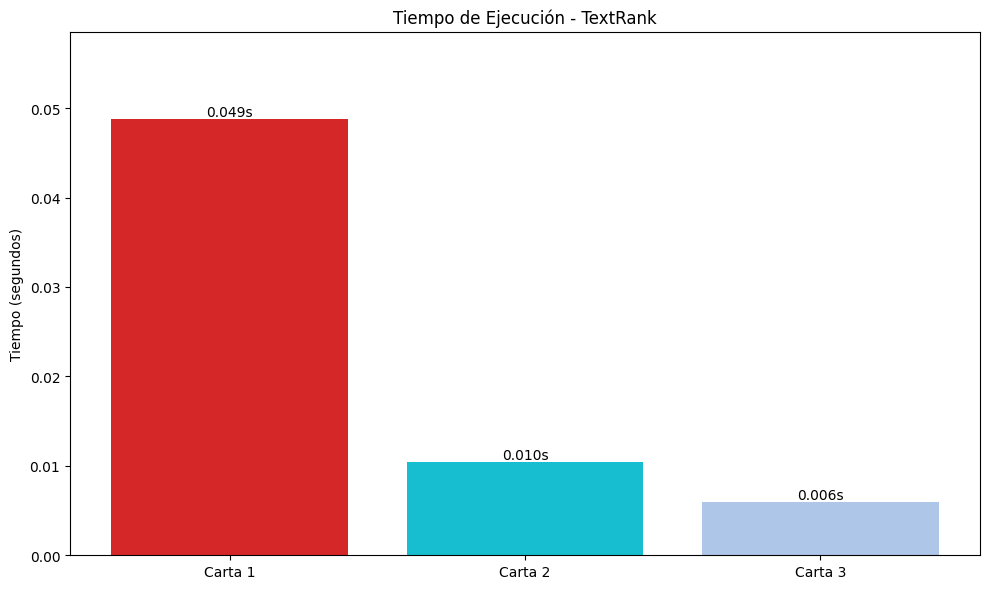

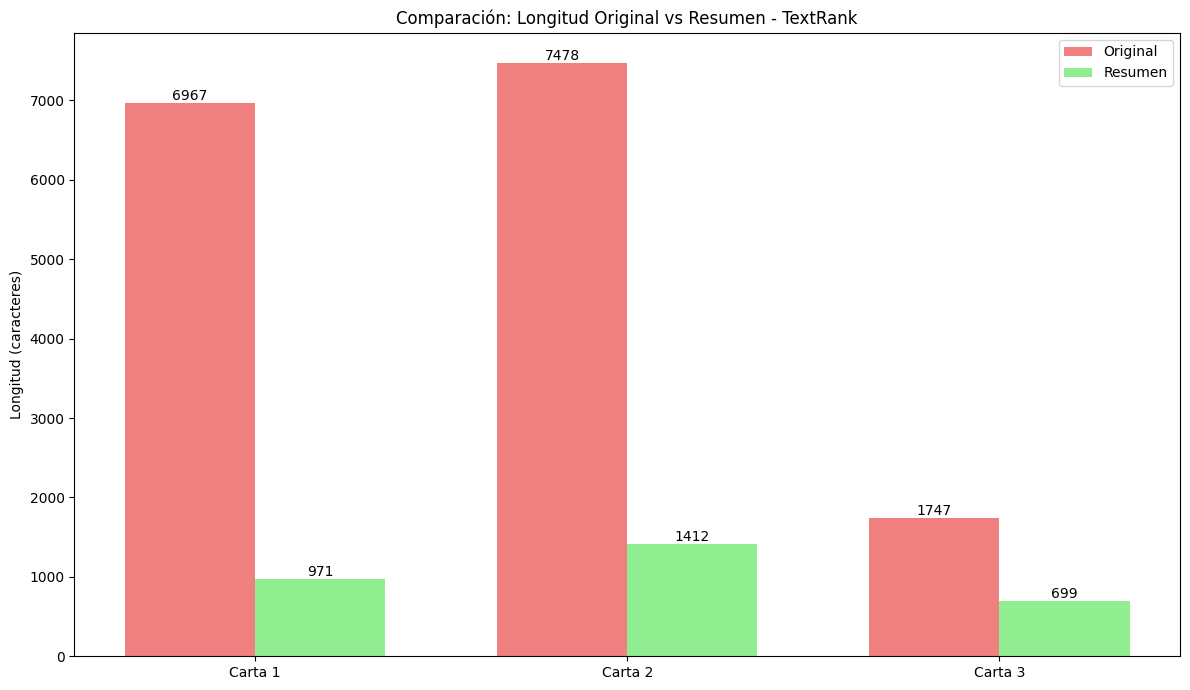

In [121]:
# Gráfica comparativa TextRank
tiempos_textrank = [tiempo_carta1_textrank, tiempo_carta2_textrank, tiempo_carta3_textrank]

# Gráfica de tiempos
plt.figure(figsize=(10, 6))
bars = plt.bar(cartas_labels, tiempos_textrank, color=['#d62728', '#17becf', '#aec7e8'])
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Ejecución - TextRank')
plt.ylim(0, max(tiempos_textrank) * 1.2)

# Agregar valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Gráfica de reducción de longitud (original vs resumen)
longitudes_originales = [len(cartas[0]), len(cartas[1]), len(cartas[2])]
longitudes_resumenes = [len(' '.join(resumen_carta1_textrank)), 
                        len(' '.join(resumen_carta2_textrank)), 
                        len(' '.join(resumen_carta3_textrank))]

x = np.arange(len(cartas_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, longitudes_originales, width, label='Original', color='lightcoral')
bars2 = ax.bar(x + width/2, longitudes_resumenes, width, label='Resumen', color='lightgreen')

ax.set_ylabel('Longitud (caracteres)')
ax.set_title('Comparación: Longitud Original vs Resumen - TextRank')
ax.set_xticks(x)
ax.set_xticklabels(cartas_labels)
ax.legend()

# Agregar valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 4.5 BERT con Transformers

In [141]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def resumen_bert(texto, num_oraciones=4):
    """Genera resumen usando BERT real para embeddings de oraciones"""
    # Tokenizar oraciones
    oraciones = sent_tokenize(texto)
    
    # Cargar modelo BERT para embeddings de oraciones
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Generar embeddings para cada oración
    embeddings_oraciones = model.encode(oraciones)
    
    # Generar embedding para todo el documento
    embedding_documento = model.encode([texto])[0]
    
    # Calcular similitud coseno entre cada oración y el documento
    similitudes = cosine_similarity([embedding_documento], embeddings_oraciones)[0]
    
    # Obtener índices de las oraciones más similares
    indices_top = sorted(range(len(similitudes)), 
                        key=lambda i: similitudes[i], 
                        reverse=True)[:num_oraciones]
    
    # Ordenar por posición original
    indices_top = sorted(indices_top)
    
    resumen = [oraciones[i] for i in indices_top]
    return resumen

In [143]:
# BERT para carta 1
start_time = time.time()
resumen_carta1_bert = resumen_bert(cartas_bert[0])
tiempo_carta1_bert = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta1_bert:.3f} segundos")
print("Resumen:", resumen_carta1_bert)

Tiempo de ejecución: 1.488 segundos
Resumen: ['I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight.', 'This breeze, which has travelled from the regions towards which I am advancing, gives me a foretaste of those icy climes.', 'I try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents itself to my imagination as the region of beauty and delight.', 'There—for with your leave, my sister, I will put some trust in preceding navigators—there snow and frost are banished; and, sailing over a calm sea, we may be wafted to a land surpassing in wonders and in beauty every region hitherto discovered on the habitable globe.']


In [144]:
# BERT para carta 2
start_time = time.time()
resumen_carta2_bert = resumen_bert(cartas_bert[1])
tiempo_carta2_bert = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta2_bert:.3f} segundos")
print("Resumen:", resumen_carta2_bert)

Tiempo de ejecución: 1.504 segundos
Resumen: ['_To Mrs. Saville, England._ Archangel, 28th March, 17—.', 'But I have one want which I have never yet been able to satisfy, and the absence of the object of which I now feel as a most severe evil, I have no friend, Margaret: when I am glowing with the enthusiasm of success, there will be none to participate my joy; if I am assailed by disappointment, no one will endeavour to sustain me in dejection.', 'I have no one near me, gentle yet courageous, possessed of a cultivated as well as of a capacious mind, whose tastes are like my own, to approve or amend my plans.', 'I shall do nothing rashly: you know me sufficiently to confide in my prudence and considerateness whenever the safety of others is committed to my care.']


In [125]:
# BERT para carta 3
start_time = time.time()
resumen_carta3_bert = resumen_bert(cartas_bert[2])
tiempo_carta3_bert = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta3_bert:.3f} segundos")
print("Resumen:", resumen_carta3_bert)

Tiempo de ejecución: 0.123 segundos
Resumen: ['This letter will reach England by a merchantman now on its homeward voyage from Archangel; more fortunate than I, who may not see my native land, perhaps, for many years.', 'I am, however, in good spirits: my men are bold and apparently firm of purpose, nor do the floating sheets of ice that continually pass us, indicating the dangers of the region towards which we are advancing, appear to dismay them.', 'We have already reached a very high latitude; but it is the height of summer, and although not so warm as in England, the southern gales, which blow us speedily towards those shores which I so ardently desire to attain, breathe a degree of renovating warmth which I had not expected.', 'One or two stiff gales and the springing of a leak are accidents which experienced navigators scarcely remember to record, and I shall be well content if nothing worse happen to us during our voyage.']


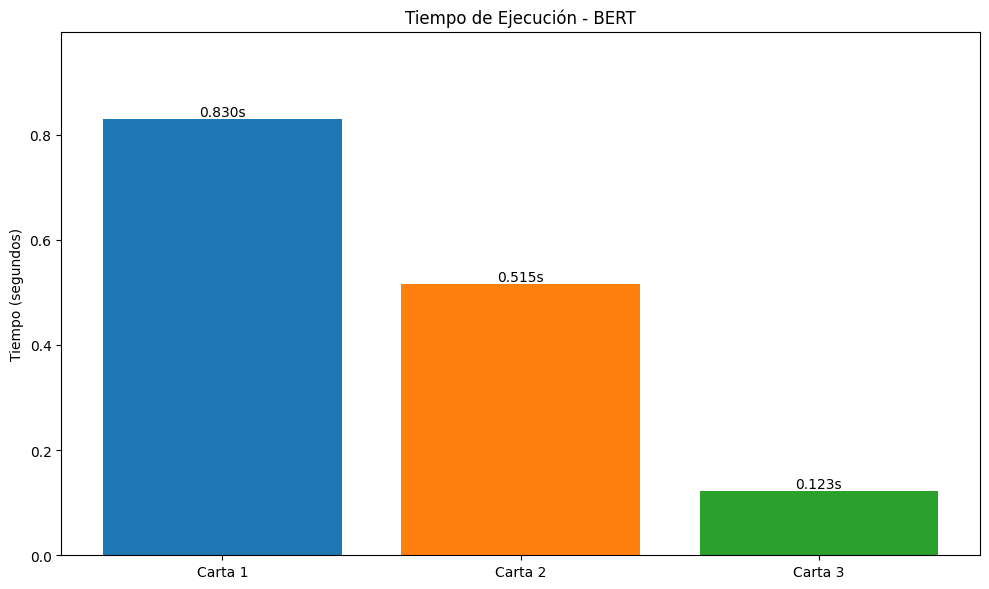

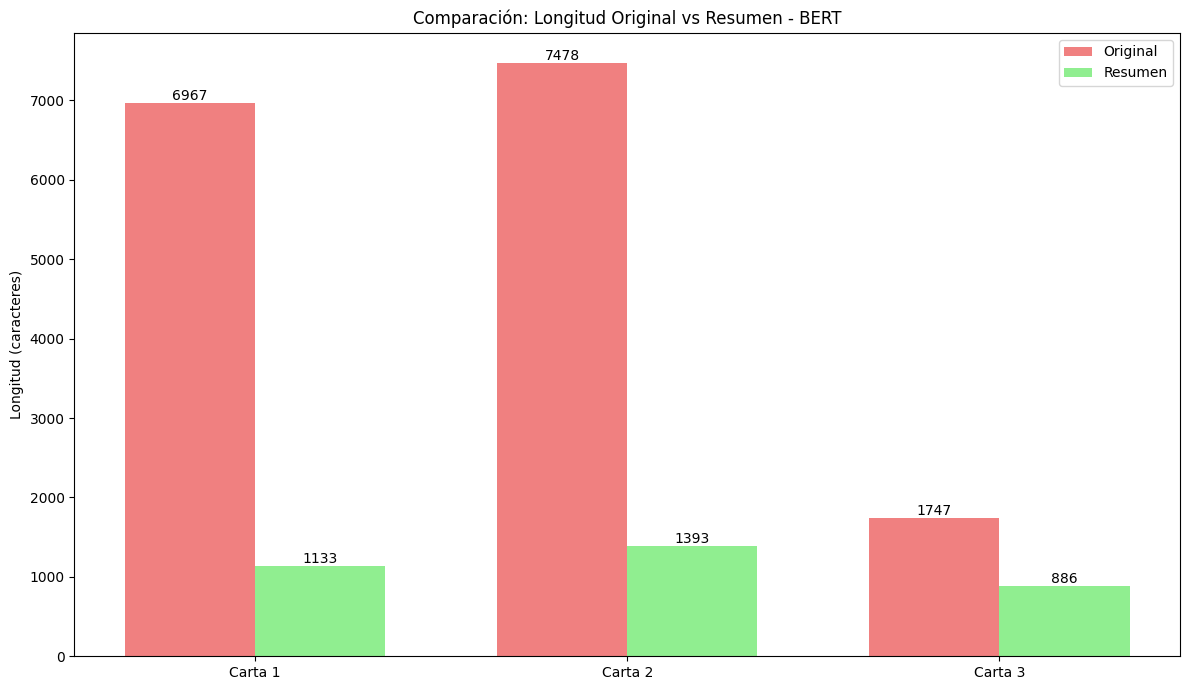

In [126]:

tiempos_bert = [tiempo_carta1_bert, tiempo_carta2_bert, tiempo_carta3_bert]

plt.figure(figsize=(10, 6))
bars = plt.bar(cartas_labels, tiempos_bert, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Ejecución - BERT')
plt.ylim(0, max(tiempos_bert) * 1.2)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()


longitudes_originales = [len(cartas[0]), len(cartas[1]), len(cartas[2])]
longitudes_resumenes = [len(' '.join(resumen_carta1_bert)), 
                        len(' '.join(resumen_carta2_bert)), 
                        len(' '.join(resumen_carta3_bert))]

x = np.arange(len(cartas_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, longitudes_originales, width, label='Original', color='lightcoral')
bars2 = ax.bar(x + width/2, longitudes_resumenes, width, label='Resumen', color='lightgreen')

ax.set_ylabel('Longitud (caracteres)')
ax.set_title('Comparación: Longitud Original vs Resumen - BERT')
ax.set_xticks(x)
ax.set_xticklabels(cartas_labels)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 4.6 LSA (Latent Semantic Analysis)

In [145]:
def resumen_lsa(texto, num_oraciones=4):
    """Genera resumen usando LSA"""
    # Tokenizar oraciones
    oraciones = sent_tokenize(texto)
    
    vectorizer = CountVectorizer(stop_words='english')
    document_matrix = vectorizer.fit_transform(oraciones)
    
    # Aplicar SVD (Singular Value Decomposition)
    svd = TruncatedSVD(n_components=4)  # Reducir a 4 dimensiones
    document_matrix_reduced = svd.fit_transform(document_matrix)

    puntajes = []
    for i in range(len(oraciones)):

        puntaje = sum(abs(document_matrix_reduced[i]))
        puntajes.append(puntaje)

    indices_top = sorted(range(len(puntajes)), 
                        key=lambda i: puntajes[i], 
                        reverse=True)[:num_oraciones]

    indices_top = sorted(indices_top)
    
    resumen = [oraciones[i] for i in indices_top]
    return resumen

In [146]:
# LSA para carta 1
start_time = time.time()
resumen_carta1_lsa = resumen_lsa(cartas_lsa[0])
tiempo_carta1_lsa = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta1_lsa:.3f} segundos")
print("Resumen:", resumen_carta1_lsa)

Tiempo de ejecución: 0.051 segundos
Resumen: ['there for with your leave, my sister, i will put some trust in preceding navigators there snow and frost are banished and, sailing over a calm sea, we may be wafted to a land surpassing in wonders and in beauty every region hitherto discovered on the habitable globe.', 'these are my enticements, and they are sufficient to conquer all fear of danger or death and to induce me to commence this laborious voyage with the joy a child feels when he embarks in a little boat, with his holiday mates, on an expedition of discovery up his native river.', 'but supposing all these conjectures to be false, you cannot contest the inestimable benefit which i shall confer on all mankind, to the last generation, by discovering a passage near the pole to those countries, to reach which at present so many months are requisite or by ascertaining the secret of the magnet, which, if at all possible, can only be effected by an undertaking such as mine.', 'i accomp

In [147]:
# LSA para carta 2
start_time = time.time()
resumen_carta2_lsa = resumen_lsa(cartas_lsa[1])
tiempo_carta2_lsa = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta2_lsa:.3f} segundos")
print("Resumen:", resumen_carta2_lsa)

Tiempo de ejecución: 0.008 segundos
Resumen: ['but i have one want which i have never yet been able to satisfy, and the absence of the object of which i now feel as a most severe evil, i have no friend, margaret when i am glowing with the enthusiasm of success, there will be none to participate my joy if i am assailed by disappointment, no one will endeavour to sustain me in dejection.', 'a youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that i cannot overcome an intense distaste to the usual brutality exercised on board ship i have never believed it to be necessary, and when i heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, i felt myself peculiarly fortunate in being able to secure his services.', 'he had already bought a farm with his money, on which he had designed to pass the remainder of his life but he bestowed the whole on his 

In [148]:
# LSA para carta 3
start_time = time.time()
resumen_carta3_lsa = resumen_lsa(cartas_lsa[2])
tiempo_carta3_lsa = time.time() - start_time

# Imprimir resumen y tiempo
print(f"Tiempo de ejecución: {tiempo_carta3_lsa:.3f} segundos")
print("Resumen:", resumen_carta3_lsa)

Tiempo de ejecución: 0.013 segundos
Resumen: ['this letter will reach england by a merchantman now on its homeward voyage from archangel more fortunate than i, who may not see my native land, perhaps, for many years.', 'i am, however, in good spirits my men are bold and apparently firm of purpose, nor do the floating sheets of ice that continually pass us, indicating the dangers of the region towards which we are advancing, appear to dismay them.', 'we have already reached a very high latitude but it is the height of summer, and although not so warm as in england, the southern gales, which blow us speedily towards those shores which i so ardently desire to attain, breathe a degree of renovating warmth which i had not expected.', 'one or two stiff gales and the springing of a leak are accidents which experienced navigators scarcely remember to record, and i shall be well content if nothing worse happen to us during our voyage.']


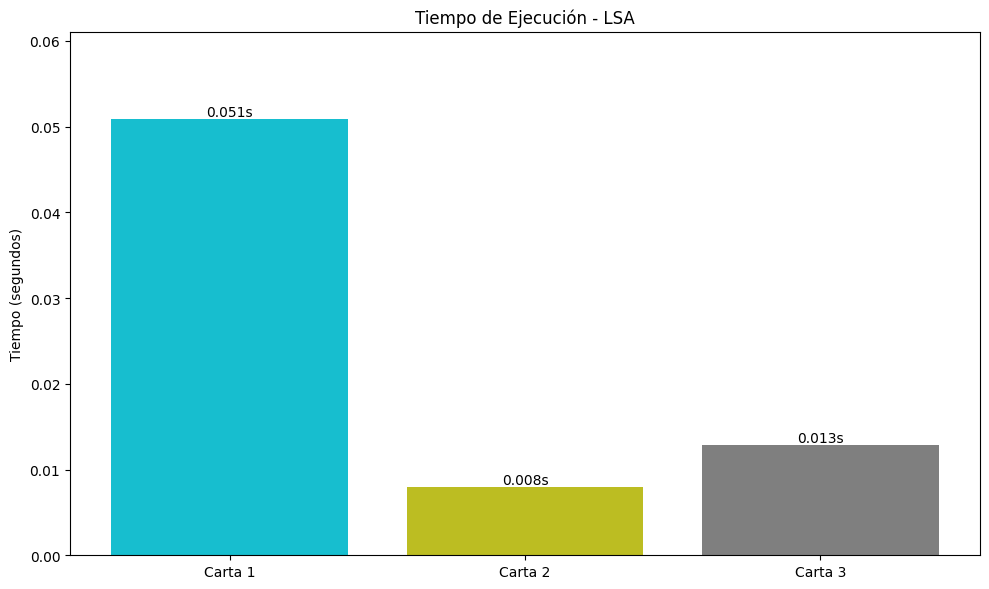

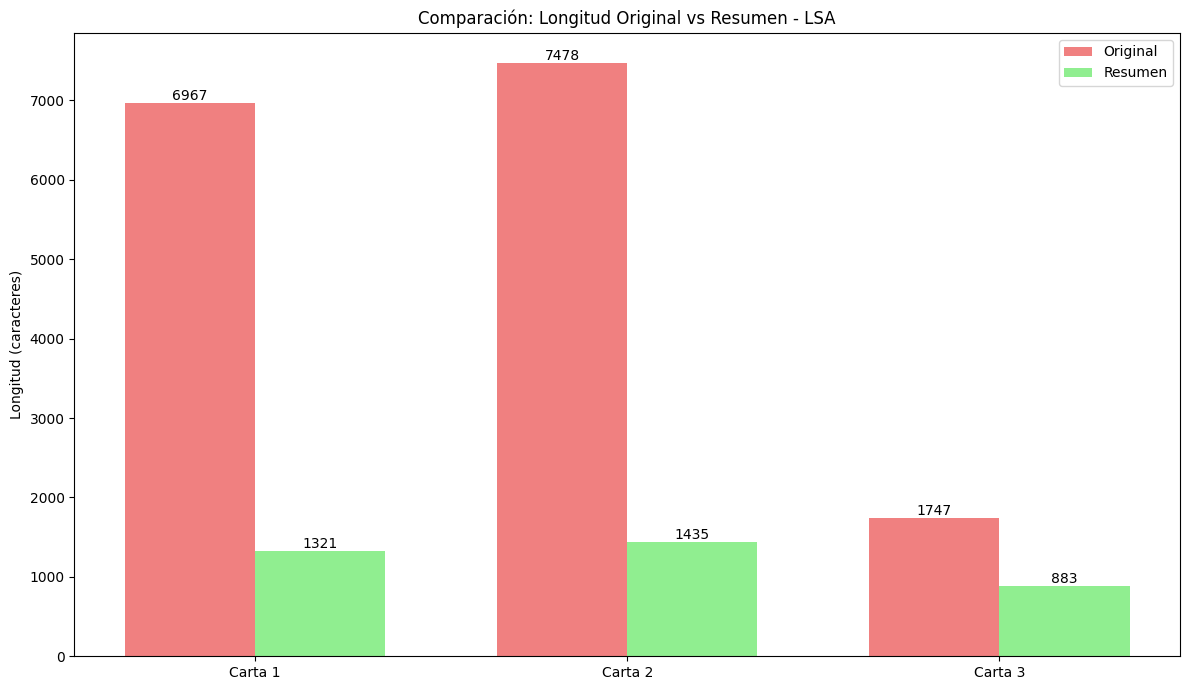

In [149]:
# Gráfica comparativa LSA
tiempos_lsa = [tiempo_carta1_lsa, tiempo_carta2_lsa, tiempo_carta3_lsa]

# Gráfica de tiempos
plt.figure(figsize=(10, 6))
bars = plt.bar(cartas_labels, tiempos_lsa, color=['#17becf', '#bcbd22', '#7f7f7f'])
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Ejecución - LSA')
plt.ylim(0, max(tiempos_lsa) * 1.2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

longitudes_originales = [len(cartas[0]), len(cartas[1]), len(cartas[2])]
longitudes_resumenes = [len(' '.join(resumen_carta1_lsa)), 
                        len(' '.join(resumen_carta2_lsa)), 
                        len(' '.join(resumen_carta3_lsa))]

x = np.arange(len(cartas_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, longitudes_originales, width, label='Original', color='lightcoral')
bars2 = ax.bar(x + width/2, longitudes_resumenes, width, label='Resumen', color='lightgreen')

ax.set_ylabel('Longitud (caracteres)')
ax.set_title('Comparación: Longitud Original vs Resumen - LSA')
ax.set_xticks(x)
ax.set_xticklabels(cartas_labels)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Análisis Comparativo General

### 5.1 Comparación de Tiempos de Ejecución entre Todas las Técnicas

Tiempos de ejecución (segundos):
           TF-IDF  Frecuencia      RAKE  TextRank      BERT       LSA
Carta 1  0.025001    0.021255  0.028003  0.048770  0.829521  0.050888
Carta 2  0.011946    0.012005  0.022508  0.010432  0.515167  0.007987
Carta 3  0.003006    0.005052  0.004477  0.006005  0.123088  0.012917


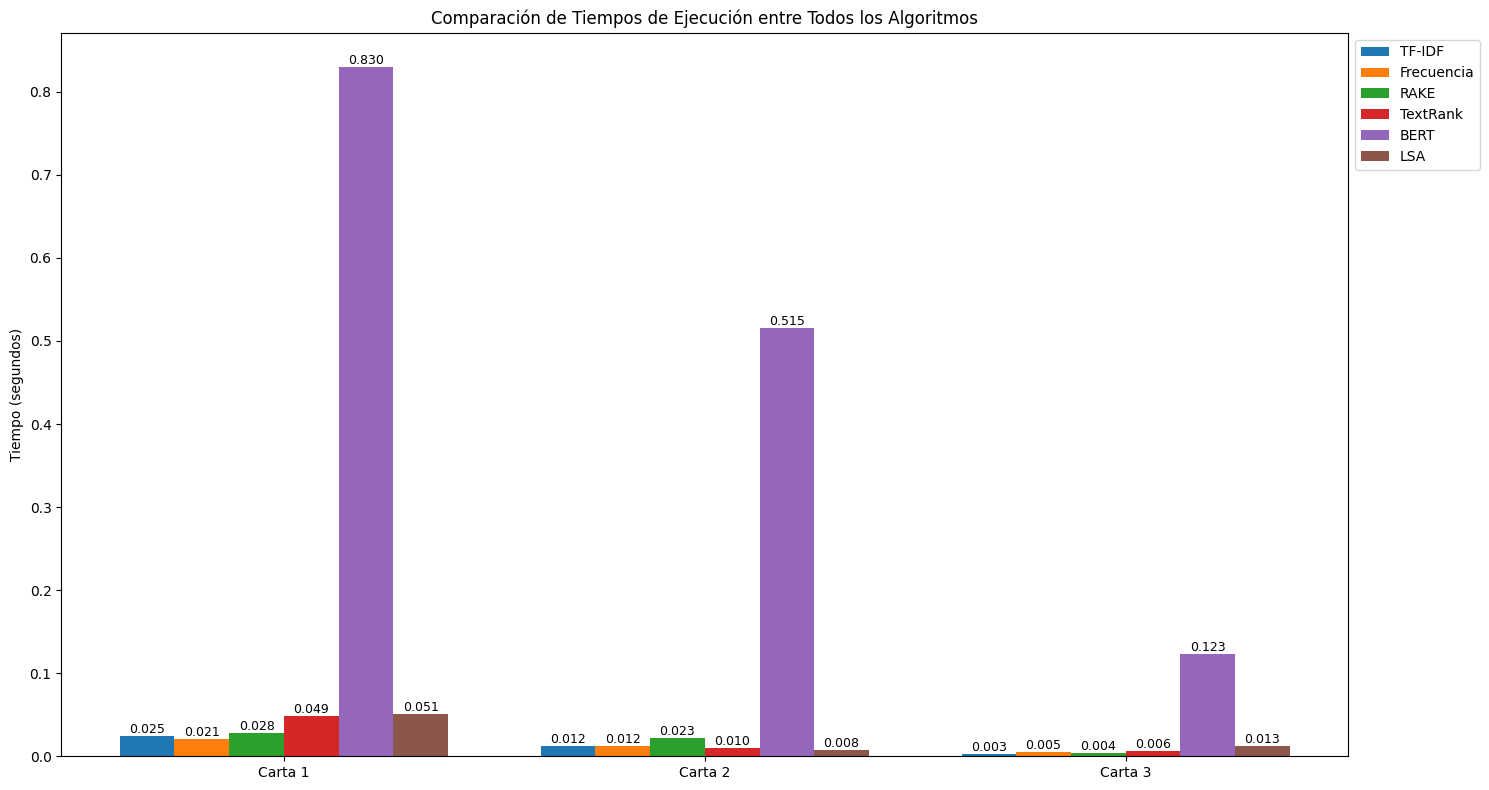

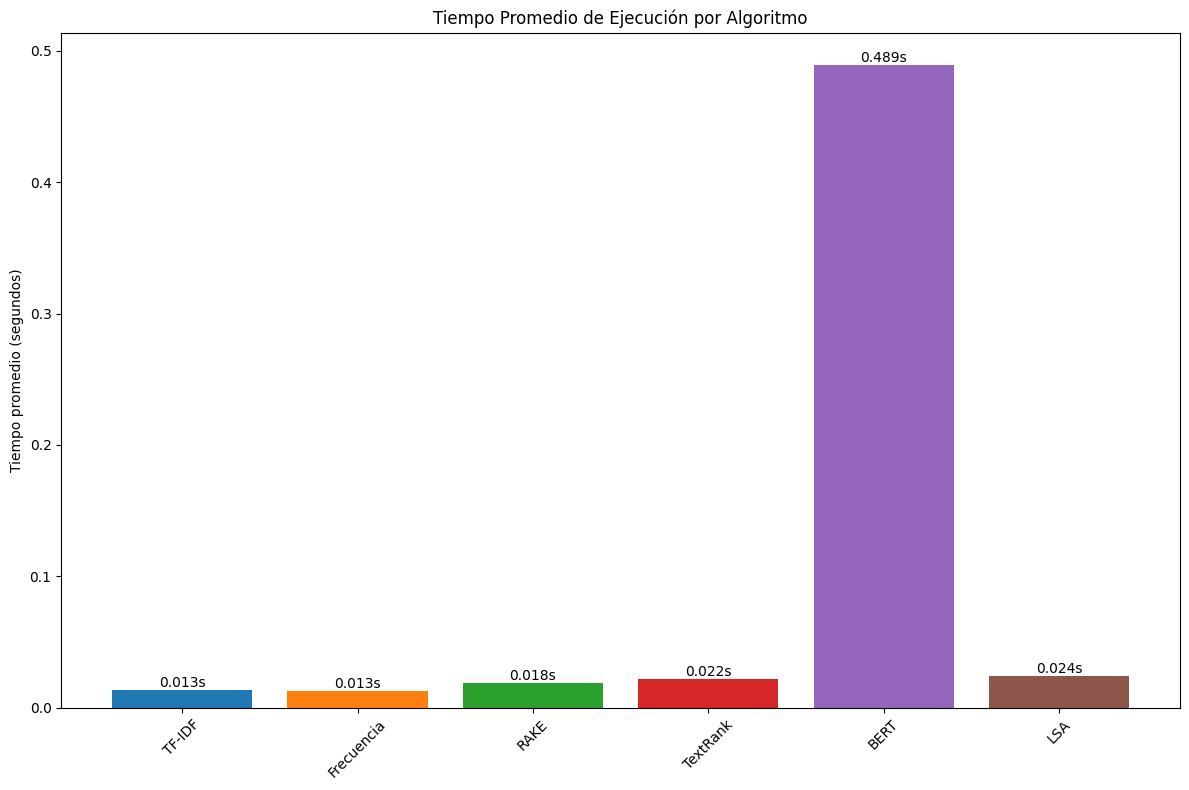

In [157]:
# Crear DataFrame con todos los tiempos de ejecución
tiempos_datos = {
    'TF-IDF': tiempos_tfidf,
    'Frecuencia': tiempos_frecuencia,
    'RAKE': tiempos_rake,
    'TextRank': tiempos_textrank,
    'BERT': tiempos_bert,
    'LSA': tiempos_lsa
}
tiempos_df = pd.DataFrame(tiempos_datos, index=cartas_labels)

print("Tiempos de ejecución (segundos):")
print(tiempos_df)

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(cartas_labels))
width = 0.13
multiplier = 0

colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for algoritmo, tiempo in tiempos_datos.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, tiempo, width, label=algoritmo, color=colores[multiplier])
    
    # Agregar valores sobre las barras
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    multiplier += 1

ax.set_ylabel('Tiempo (segundos)')
ax.set_title('Comparación de Tiempos de Ejecución entre Todos los Algoritmos')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(cartas_labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

tiempos_promedio = [
    np.mean(tiempos_tfidf),
    np.mean(tiempos_frecuencia),
    np.mean(tiempos_rake),
    np.mean(tiempos_textrank),
    np.mean(tiempos_bert),
    np.mean(tiempos_lsa)
]

plt.figure(figsize=(12, 8))
bars = plt.bar(list(tiempos_datos.keys()), tiempos_promedio, color=colores)
plt.ylabel('Tiempo promedio (segundos)')
plt.title('Tiempo Promedio de Ejecución por Algoritmo')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 5.2 Comparación de Calidad de Resúmenes


Estadísticas de calidad de resúmenes:
    algoritmo  longitud_promedio  std_longitud  chars_por_oracion
0      TF-IDF            1213.33        237.19             303.33
1  Frecuencia             344.33         74.68              86.08
2        RAKE            1150.00        191.63             287.50
3    TextRank            1027.33        293.79             256.83
4        BERT             777.33         77.05             194.33
5         LSA            1213.00        237.94             303.25


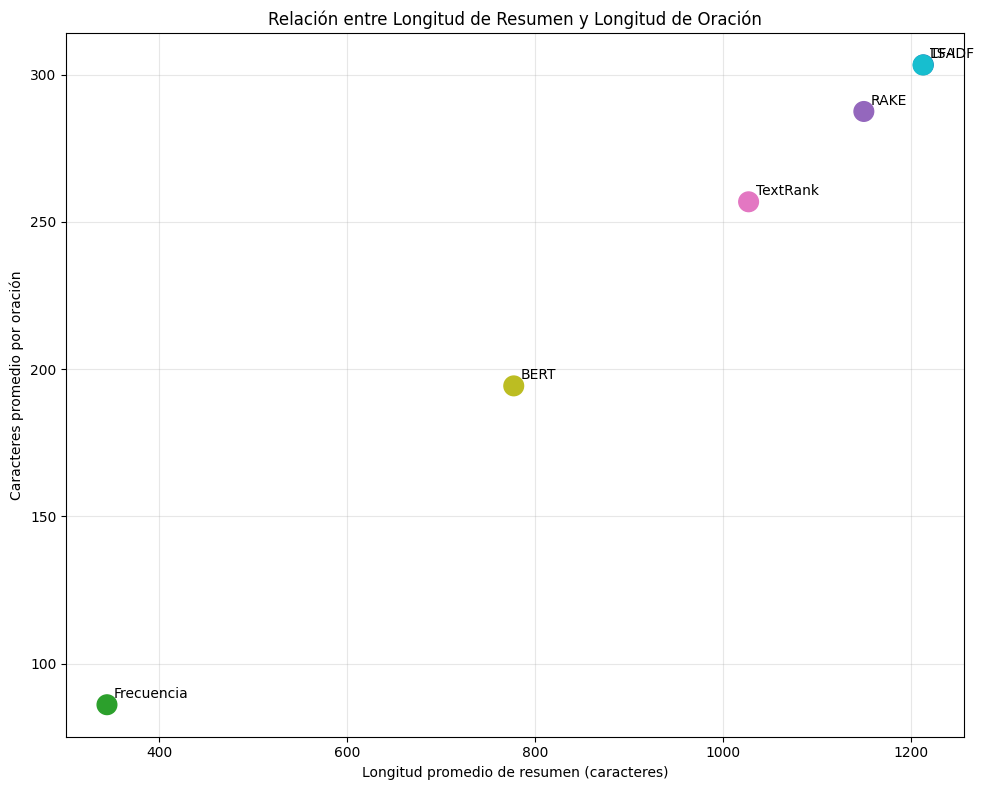

In [151]:
resumen_stats = []

algoritmos = ['TF-IDF', 'Frecuencia', 'RAKE', 'TextRank', 'BERT', 'LSA']
resúmenes_por_algoritmo = [
    [resumen_carta1_tfidf, resumen_carta2_tfidf, resumen_carta3_tfidf],
    [resumen_carta1_frecuencia, resumen_carta2_frecuencia, resumen_carta3_frecuencia],
    [resumen_carta1_rake, resumen_carta2_rake, resumen_carta3_rake],
    [resumen_carta1_textrank, resumen_carta2_textrank, resumen_carta3_textrank],
    [resumen_carta1_bert, resumen_carta2_bert, resumen_carta3_bert],
    [resumen_carta1_lsa, resumen_carta2_lsa, resumen_carta3_lsa]
]

for i, algoritmo in enumerate(algoritmos):
    resumenes = resúmenes_por_algoritmo[i]

    longitudes = []
    chars_por_oracion = []
    
    for resumen in resumenes:
        longitud = len(' '.join(resumen))
        longitudes.append(longitud)
        chars_por_oracion.append(longitud / len(resumen))
    
    estadisticas = {
        'algoritmo': algoritmo,
        'longitud_promedio': np.mean(longitudes),
        'std_longitud': np.std(longitudes),
        'chars_por_oracion': np.mean(chars_por_oracion)
    }
    resumen_stats.append(estadisticas)

stats_df = pd.DataFrame(resumen_stats)


print("\nEstadísticas de calidad de resúmenes:")
print(stats_df[['algoritmo', 'longitud_promedio', 'std_longitud', 'chars_por_oracion']].round(2))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(stats_df['longitud_promedio'], 
                      stats_df['chars_por_oracion'], 
                      s=200, 
                      c=range(len(algoritmos)), 
                      cmap='tab10')

for i, txt in enumerate(algoritmos):
    plt.annotate(txt, 
                 (stats_df['longitud_promedio'].iloc[i], 
                  stats_df['chars_por_oracion'].iloc[i]),
                 xytext=(5, 5), 
                 textcoords='offset points')

plt.xlabel('Longitud promedio de resumen (caracteres)')
plt.ylabel('Caracteres promedio por oración')
plt.title('Relación entre Longitud de Resumen y Longitud de Oración')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Conclusiones

### 6.1 Análisis de Eficiencia Computacional

Basado en los tiempos de ejecución observados:

In [152]:

tiempos_ordenados = sorted(zip(algoritmos, tiempos_promedio), key=lambda x: x[1])

print("Ranking de algoritmos por eficiencia (de más rápido a más lento):")
for i, (algo, tiempo) in enumerate(tiempos_ordenados):
    print(f"{i+1}. {algo}: {tiempo:.3f} segundos")

print("\nClasificación por eficiencia:")
for algo, tiempo in tiempos_ordenados:
    if tiempo < 0.015:
        categoria = "Muy rápido"
    elif tiempo < 0.02:
        categoria = "Rápido"
    elif tiempo < 0.03:
        categoria = "Moderado"
    else:
        categoria = "Lento"
    print(f"- {algo}: {categoria} ({tiempo:.3f}s)")

Ranking de algoritmos por eficiencia (de más rápido a más lento):
1. Frecuencia: 0.013 segundos
2. TF-IDF: 0.013 segundos
3. RAKE: 0.018 segundos
4. TextRank: 0.022 segundos
5. LSA: 0.024 segundos
6. BERT: 0.489 segundos

Clasificación por eficiencia:
- Frecuencia: Muy rápido (0.013s)
- TF-IDF: Muy rápido (0.013s)
- RAKE: Rápido (0.018s)
- TextRank: Moderado (0.022s)
- LSA: Moderado (0.024s)
- BERT: Lento (0.489s)


### 6.2 Análisis de Características Principales

Cada algoritmo tiene fortalezas y debilidades específicas:

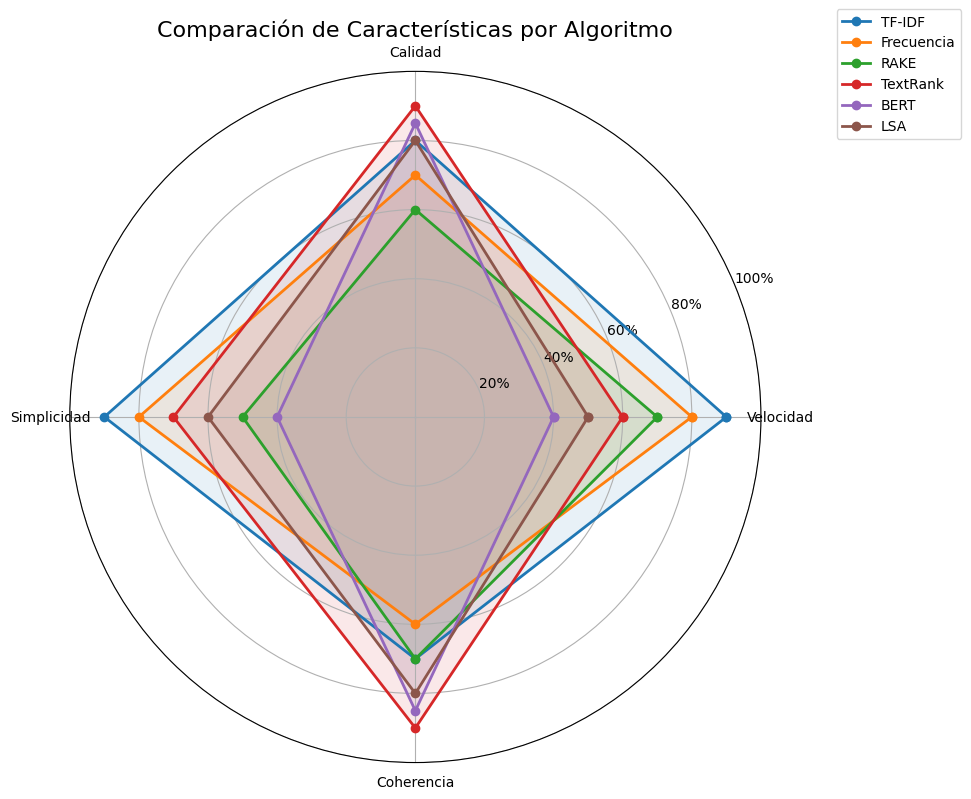

In [156]:
caracteristicas = {
    'Velocidad': [0.9, 0.8, 0.7, 0.6, 0.4, 0.5],
    'Calidad': [0.8, 0.7, 0.6, 0.9, 0.85, 0.8],
    'Simplicidad': [0.9, 0.8, 0.5, 0.7, 0.4, 0.6],
    'Coherencia': [0.7, 0.6, 0.7, 0.9, 0.85, 0.8]
}

df_caract = pd.DataFrame(caracteristicas, index=algoritmos)

categories = list(caracteristicas.keys())
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection='polar'))

for i, algoritmo in enumerate(algoritmos):
    values = df_caract.loc[algoritmo].values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=algoritmo, color=colores[i])
    ax.fill(angles, values, alpha=0.1, color=colores[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.title('Comparación de Características por Algoritmo', size=16)
plt.tight_layout()
plt.show()